In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob

file_car = r'E:\safety_sim\dataset\범죄안전데이터\서울시 경찰청별 범죄 발생 및 검거 현황\불법주정차 신고현황'
file_cctv =r"E:\safety_sim\dataset\위치 데이터\cctv데이터.xlsx"
file_list = glob.glob(f"{file_car}/*.csv")

dataframes =[]
for data in file_list:
    df = pd.read_csv(data)
    dataframes.append(df)

df_park = pd.concat(dataframes, ignore_index=True)
df_park.head(2)

,민원접수일,민원접수시간,주소,경도,위도
0,20210929,00:05:00,서울 강서구 화곡로66길 130,126.859911,37.555537
1,20210929,00:38:00,중구 다산로48길 33 단우물어린이집앞,127.018013,37.567483


In [14]:
# CCTV 데이터 불러오기
cctv_data = pd.read_excel(file_cctv)

# 데이터 확인
cctv_data.head(2)


e:\Anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,번호,관리기관명,소재지도로명주소,소재지지번주소,설치목적구분,카메라대수,카메라화소수,촬영방면정보,보관일수,설치연월,관리기관전화번호,WGS84위도,WGS84경도,데이터기준일자
0,1,서울특별시 성동구청,서울특별시 마조로 11,서울특별시 행당동 19-98,교통단속,3,200,360도전방면,30,2013-11,02-2286-5878,37.558960,127.040794,2022-06-24
1,2,서울특별시 성동구청,서울특별시 고산자로 330 (마장동),서울특별시 마장동 520-10,교통단속,2,200,360도전방면,30,2013-11,02-2286-5878,37.569137,127.037521,2022-06-24


In [15]:
# 2) 결측치·이상치 제거 및 타입 변환
df_park = df_park.dropna(subset=['위도','경도'])
df_park['위도'] = pd.to_numeric(df_park['위도'], errors='coerce')
df_park['경도'] = pd.to_numeric(df_park['경도'], errors='coerce')
# 서울시 대략 범위(위도 37.4~37.7, 경도 126.7~127.2) 밖 데이터 제거
df_park = df_park[
    df_park['위도'].between(37.4,37.7) & df_park['경도'].between(126.7,127.2)
].reset_index(drop=True)

In [16]:
df_cctv= cctv_data 

In [17]:
# 3) CCTV 데이터 불러오기 및 전처리

df_cctv = df_cctv.dropna(subset=['WGS84위도','WGS84경도'])
df_cctv['카메라대수'] = pd.to_numeric(df_cctv['카메라대수'], errors='coerce').fillna(1)
df_cctv['카메라대수'] = pd.to_numeric(df_cctv['카메라대수'], errors='coerce').fillna(1)

In [18]:
# 4) 간단한 그리드(격자) 생성: 0.01° 단위
grid_size = 0.01
df_park['lat_grid'] = (df_park['위도'] / grid_size).round() * grid_size
df_park['lon_grid'] = (df_park['경도'] / grid_size).round() * grid_size
df_cctv['lat_grid']  = (df_cctv['WGS84위도'] / grid_size).round() * grid_size
df_cctv['lon_grid']  = (df_cctv['WGS84경도'] / grid_size).round() * grid_size

In [19]:

# 5) 그리드별 집계
park_agg = (
    df_park
    .groupby(['lat_grid','lon_grid'])
    .size()
    .reset_index(name='park_count')
)
cctv_agg = (
    df_cctv
    .groupby(['lat_grid','lon_grid'])['카메라대수']
    .sum()
    .reset_index(name='cctv_count')
)

In [20]:
# 6) 병합 및 상관계수 계산
df_agg = pd.merge(park_agg, cctv_agg, on=['lat_grid','lon_grid'], how='inner')
corr = df_agg['cctv_count'].corr(df_agg['park_count'])
print(f"▶ CCTV vs 불법주정차 상관계수(Pearson): {corr:.4f}")


▶ CCTV vs 불법주정차 상관계수(Pearson): 0.4907


In [21]:
from matplotlib import colors

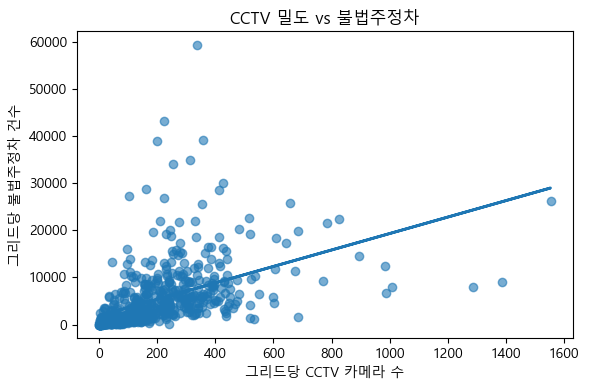

In [22]:

# 7) 산점도와 회귀선 그리기
plt.figure(figsize=(6,4))
plt.scatter(df_agg['cctv_count'], df_agg['park_count'], alpha=0.6)
m, b = np.polyfit(df_agg['cctv_count'], df_agg['park_count'], 1)
plt.plot(df_agg['cctv_count'], m*df_agg['cctv_count']+b, lw=2)
plt.xlabel('그리드당 CCTV 카메라 수')
plt.ylabel('그리드당 불법주정차 건수')
plt.title('CCTV 밀도 vs 불법주정차')
plt.tight_layout()
plt.show()   # <- 이 줄 추가


In [23]:
# 8) 딥러닝 모델링: CCTV 수로 불법주정차 건수 예측 (회귀)
class ParkingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class Net(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers):
        super().__init__()
        layers=[]
        in_dim = input_dim
        for _ in range(num_layers):
            layers += [nn.Linear(in_dim, hidden_size), nn.ReLU()]
            in_dim = hidden_size
        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)

In [24]:

# 피처·타겟 준비
X = df_agg[['cctv_count']].values
y = df_agg['park_count'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
train_ds = ParkingDataset(X_train, y_train)
val_ds   = ParkingDataset(X_val, y_val)

In [25]:
# 9) 하이퍼파라미터 그리드 탐색
param_grid = {
    'hidden_size': [16, 32, 64],
    'num_layers': [1, 2],
    'lr': [1e-2, 1e-3],
    'batch_size': [16, 32],
    'epochs': [50]
}

best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # 데이터로더
    tr_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(val_ds,   batch_size=params['batch_size'], shuffle=False)
    # 모델·옵티마이저·손실함수
    model = Net(input_dim=1,
                hidden_size=params['hidden_size'],
                num_layers=params['num_layers'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.MSELoss()
    # 학습
    for epoch in range(params['epochs']):
        model.train()
        for xb,yb in tr_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
    # 검증
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb,yb in vl_loader:
            val_losses.append(criterion(model(xb), yb).item())
    avg_val_loss = np.mean(val_losses)
    print(f"Params {params} -> Val MSE: {avg_val_loss:.4f}")
    if avg_val_loss < best_loss:
        best_loss, best_params = avg_val_loss, params

print(f"\n▶ 최적 하이퍼파라미터: {best_params}")
print(f"▶ 최종 검증 MSE: {best_loss:.4f}")

Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 16, 'lr': 0.01, 'num_layers': 1} -> Val MSE: 21861743.3750
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 16, 'lr': 0.01, 'num_layers': 2} -> Val MSE: 16886892.3750
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 16, 'lr': 0.001, 'num_layers': 1} -> Val MSE: 66317893.0000
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 16, 'lr': 0.001, 'num_layers': 2} -> Val MSE: 38028552.2500
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 32, 'lr': 0.01, 'num_layers': 1} -> Val MSE: 16908569.0000
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 32, 'lr': 0.01, 'num_layers': 2} -> Val MSE: 16609129.3750
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 32, 'lr': 0.001, 'num_layers': 1} -> Val MSE: 65166245.0000
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 32, 'lr': 0.001, 'num_layers': 2} -> Val MSE: 18868104.3750
Params {'batch_size': 16, 'epochs': 50, 'hidden_size': 64, 'lr': 0.01, 'num_layers':

In [26]:
# DataLoader 재생성
tr_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
vl_loader = DataLoader(val_ds,   batch_size=best_params['batch_size'], shuffle=False)

# 모델·옵티마이저·손실함수 초기화
model = Net(input_dim=1,
            hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

# 학습 손실 기록용 리스트
train_losses = []
val_losses   = []

In [27]:
# 재학습
for epoch in range(best_params['epochs']):
    model.train()
    epoch_train_loss = 0.0
    for xb, yb in tr_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * xb.size(0)
    epoch_train_loss /= len(tr_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # 검증 손실
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in vl_loader:
            loss = criterion(model(xb), yb)
            epoch_val_loss += loss.item() * xb.size(0)
    epoch_val_loss /= len(vl_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d}/{best_params['epochs']}  "
              f"Train MSE: {epoch_train_loss:.4f}  Val MSE: {epoch_val_loss:.4f}")


Epoch 001/50  Train MSE: 73091863.7940  Val MSE: 63419411.0769
Epoch 010/50  Train MSE: 37838509.7511  Val MSE: 16582705.6496
Epoch 020/50  Train MSE: 36638800.0901  Val MSE: 15668076.7009
Epoch 030/50  Train MSE: 35654623.0901  Val MSE: 15092346.8632
Epoch 040/50  Train MSE: 35098810.3777  Val MSE: 15407770.9573
Epoch 050/50  Train MSE: 35031088.2661  Val MSE: 15499156.4274


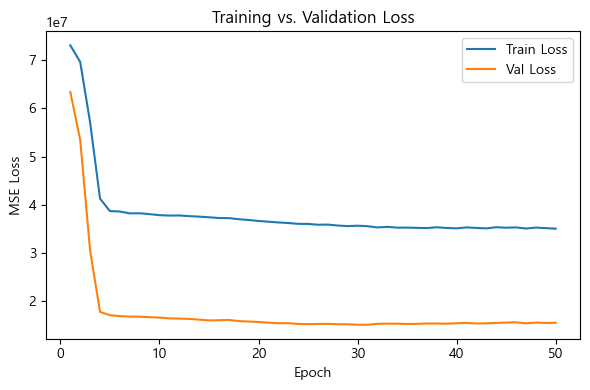

In [28]:
# 11) 손실 곡선 시각화
plt.figure(figsize=(6,4))
plt.plot(range(1, best_params['epochs']+1), train_losses, label='Train Loss')
plt.plot(range(1, best_params['epochs']+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# 12) 최종 검증 세트 성능 측정 및 예측 결과 시각화
import sklearn.metrics as metrics

# 검증 데이터 전체에 대한 예측
model.eval()
with torch.no_grad():
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    y_pred_tensor = model(X_val_tensor)
    
y_pred = y_pred_tensor.numpy().flatten()
y_true = y_val

In [30]:
# MAE, RMSE 출력
mae  = metrics.mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
print(f"▶ Validation MAE: {mae:.4f}")
print(f"▶ Validation RMSE: {rmse:.4f}")

▶ Validation MAE: 2823.1749
▶ Validation RMSE: 3936.8968


In [33]:
import numpy as np
y_mean = np.mean(y_true)
baseline_mae  = np.mean(np.abs(y_true - y_mean))
baseline_rmse = np.sqrt(np.mean((y_true - y_mean)**2))
print("▶ Baseline MAE:", baseline_mae)
print("▶ Baseline RMSE:", baseline_rmse)


▶ Baseline MAE: 4432.927460004384
▶ Baseline RMSE: 5604.901786049955


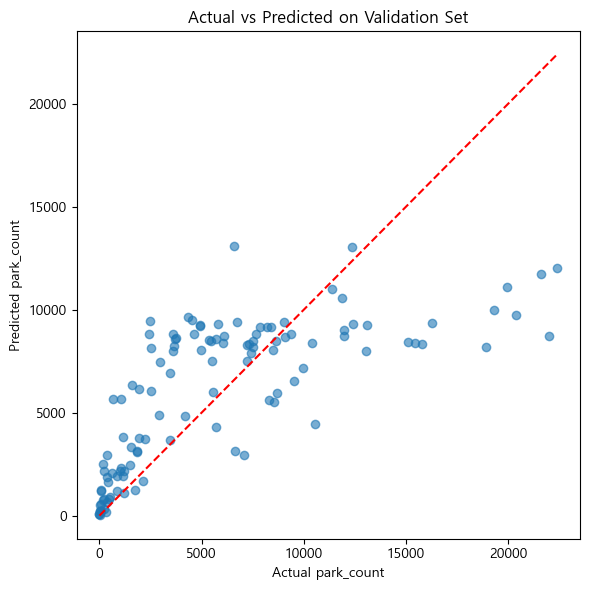

In [31]:
# 산점도
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual park_count')
plt.ylabel('Predicted park_count')
plt.title('Actual vs Predicted on Validation Set')
plt.tight_layout()
plt.show()

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
import numpy as np

# 1) Net 클래스에 드롭아웃 추가
class NetDropout(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, dropout):
        super().__init__()
        layers = []
        in_dim = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Linear(in_dim, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_dim = hidden_size
        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 2) 세밀 조정용 하이퍼파라미터 그리드
param_grid = {
    'hidden_size': [64, 96, 128],
    'num_layers':  [2, 3],
    'dropout':     [0.0, 0.1, 0.2],
    'lr':          [0.005, 0.01, 0.02],
    'weight_decay':[0.0, 1e-5, 1e-4],
    'batch_size':  [8, 16],
    'epochs':      [80]
}

best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # 데이터로더
    tr_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(val_ds,   batch_size=params['batch_size'], shuffle=False)

    # 모델·옵티마이저·손실함수
    model = NetDropout(input_dim=1,
                       hidden_size=params['hidden_size'],
                       num_layers=params['num_layers'],
                       dropout=params['dropout'])
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    criterion = nn.MSELoss()

    # 학습
    for epoch in range(params['epochs']):
        model.train()
        for xb, yb in tr_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # 검증
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in vl_loader:
            val_losses.append(criterion(model(xb), yb).item())
    avg_val_loss = np.mean(val_losses)

    print(f"Params {params} -> Val MSE: {avg_val_loss:.2f}")
    if avg_val_loss < best_loss:
        best_loss, best_params = avg_val_loss, params

print(f"\n▶ 최적 하이퍼파라미터: {best_params}")
print(f"▶ 최종 검증 MSE: {best_loss:.2f}")


Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.005, 'num_layers': 2, 'weight_decay': 0.0} -> Val MSE: 15426404.67
Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.005, 'num_layers': 2, 'weight_decay': 1e-05} -> Val MSE: 15597170.12
Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.005, 'num_layers': 2, 'weight_decay': 0.0001} -> Val MSE: 15618481.40
Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.005, 'num_layers': 3, 'weight_decay': 0.0} -> Val MSE: 15701530.75
Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.005, 'num_layers': 3, 'weight_decay': 1e-05} -> Val MSE: 15840905.75
Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.005, 'num_layers': 3, 'weight_decay': 0.0001} -> Val MSE: 16173962.87
Params {'batch_size': 8, 'dropout': 0.0, 'epochs': 80, 'hidden_size': 64, 'lr': 0.01, 'num_layer

In [35]:
# 1) 최적 파라미터 불러오기
best_params = {
    'batch_size': 16,
    'dropout': 0.1,
    'epochs': 80,
    'hidden_size': 64,
    'lr': 0.01,
    'num_layers': 2,
    'weight_decay': 0.0
}

# 2) 데이터로더 준비
tr_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
vl_loader = DataLoader(val_ds,   batch_size=best_params['batch_size'], shuffle=False)

# 3) 모델·옵티마이저·손실함수 초기화
model = NetDropout(
    input_dim=1,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)
criterion = nn.MSELoss()

# 4) 재학습 및 손실 기록
train_losses, val_losses = [], []

for epoch in range(best_params['epochs']):
    model.train()
    epoch_tr, epoch_vl = 0.0, 0.0
    
    # -- Train --
    for xb, yb in tr_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_tr += loss.item() * xb.size(0)
    epoch_tr /= len(tr_loader.dataset)
    train_losses.append(epoch_tr)
    
    # -- Val --
    model.eval()
    with torch.no_grad():
        for xb, yb in vl_loader:
            loss = criterion(model(xb), yb)
            epoch_vl += loss.item() * xb.size(0)
    epoch_vl /= len(vl_loader.dataset)
    val_losses.append(epoch_vl)
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d}/{best_params['epochs']}  "
              f"Train MSE: {epoch_tr:.2f}  Val MSE: {epoch_vl:.2f}")

# 5) 최종 Epoch 성능 출력
print(f"\n▶ Final Train MSE: {train_losses[-1]:.2f}")
print(f"▶ Final Val   MSE: {val_losses[-1]:.2f}")

# 6) MAE·RMSE 계산
import sklearn.metrics as metrics
model.eval()
with torch.no_grad():
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_pred_t = model(X_val_t).numpy().flatten()
y_true = y_val
mae  = metrics.mean_absolute_error(y_true, y_pred_t)
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred_t))
print(f"▶ Validation MAE:  {mae:.2f}")
print(f"▶ Validation RMSE: {rmse:.2f}")

Epoch 001/80  Train MSE: 73139151.66  Val MSE: 63729040.07
Epoch 010/80  Train MSE: 38581266.33  Val MSE: 16672057.86
Epoch 020/80  Train MSE: 38304610.83  Val MSE: 16285697.50
Epoch 030/80  Train MSE: 37197488.40  Val MSE: 15770805.74
Epoch 040/80  Train MSE: 36645662.48  Val MSE: 15316864.36
Epoch 050/80  Train MSE: 36219802.07  Val MSE: 15248174.31
Epoch 060/80  Train MSE: 36709471.82  Val MSE: 15442594.85
Epoch 070/80  Train MSE: 36463534.40  Val MSE: 15438576.56
Epoch 080/80  Train MSE: 36585604.27  Val MSE: 15405835.47

▶ Final Train MSE: 36585604.27
▶ Final Val   MSE: 15405835.47
▶ Validation MAE:  2924.36
▶ Validation RMSE: 3925.03


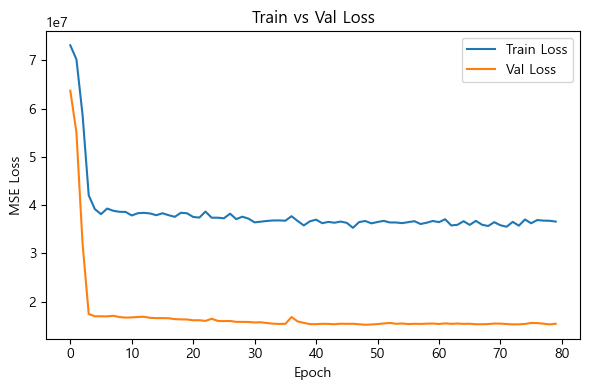

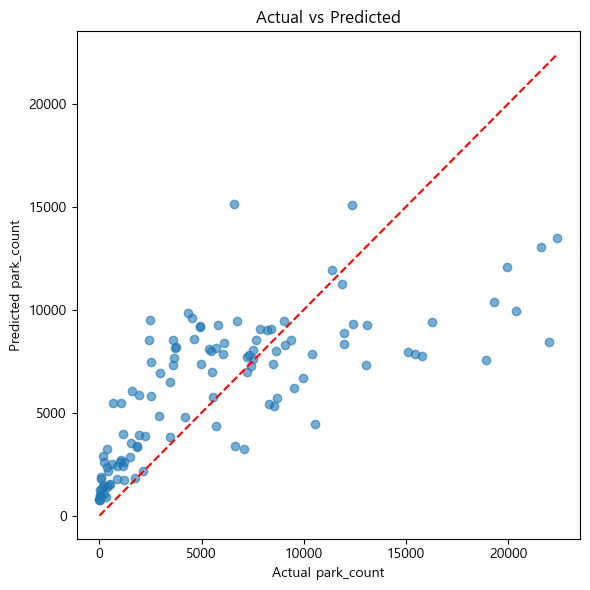

✅ 최종 모델과 스케일러를 'best_parking_model_dropout.pth'로 저장했습니다.


In [36]:
# 7) 손실 곡선 시각화
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 8) Actual vs Predicted 산점도
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_t, alpha=0.6)
lims = [min(y_true.min(), y_pred_t.min()), max(y_true.max(), y_pred_t.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual park_count')
plt.ylabel('Predicted park_count')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

# 9) 모델·스케일러 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'params': best_params
}, 'best_parking_model_dropout.pth')
print("✅ 최종 모델과 스케일러를 'best_parking_model_dropout.pth'로 저장했습니다.")